In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 985
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  LHARVKFK_11_51_10
NN-MODEL FILENAME:  ./models/LHARVKFK_11_51_10_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((node_id%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1249.60 MiB, increment: 1029.71 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 22778 EXPERIENCES:0:00:01.134070


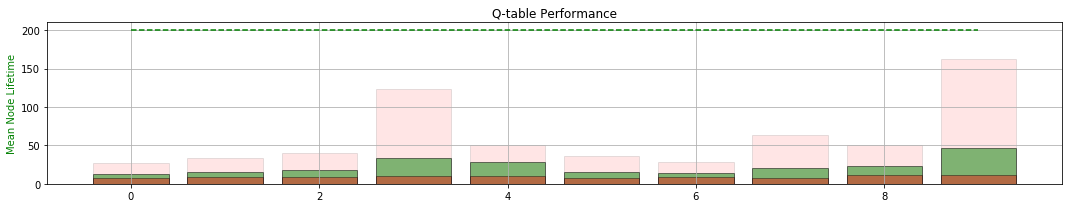

MEMORY COUNTER:  22778
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 5.536	LOSS : 5.346	LOSS : 5.163	LOSS : 5.003	LOSS : 4.877	LOSS : 4.690	
Validating... MEAN TIME:  130.765
LOSS : 4.945	LOSS : 4.707	LOSS : 4.785	LOSS : 4.770	LOSS : 4.577	LOSS : 4.686	
Validating... MEAN TIME:  143.005
LOSS : 4.547	LOSS : 4.655	LOSS : 4.738	LOSS : 4.688	LOSS : 4.511	LOSS : 4.865	
Validating... MEAN TIME:  131.58
LOSS : 4.473	LOSS : 4.432	LOSS : 4.544	LOSS : 4.656	LOSS : 4.553	LOSS : 4.347	
Validating... MEAN TIME:  151.87
LOSS : 4.296	LOSS : 4.438	LOSS : 4.561	LOSS : 4.673	LOSS : 4.355	LOSS : 4.617	
Validating... MEAN TIME:  127.35
TRAINING TIME:0:00:42.156406


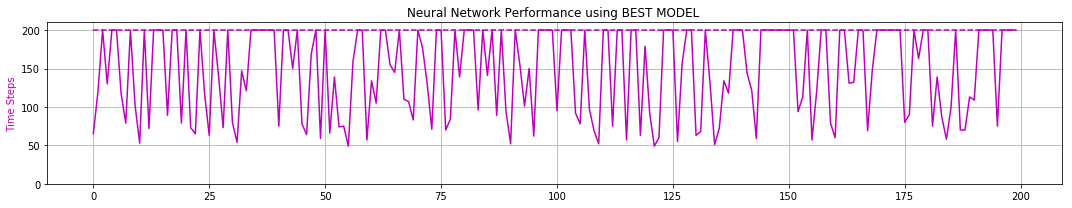

peak memory: 1347.93 MiB, increment: 1035.55 MiB
0 -max- [ 0.050  0.155  0.209  2.757]
0 -min- [-0.212 -1.804 -0.051 -0.079]

1 -max- [ 0.289  1.789  0.060  0.441]
1 -min- [-0.052 -0.245 -0.208 -2.738]

2 -max- [ 0.050  0.234  0.209  2.720]
2 -min- [-0.221 -1.785 -0.050 -0.178]

3 -max- [ 2.397  2.794  0.204  0.787]
3 -min- [-0.082 -0.560 -0.209 -2.505]

4 -max- [ 0.097  0.560  0.209  2.077]
4 -min- [-0.240 -1.219 -0.048 -0.228]

5 -max- [ 0.250  1.804  0.057  0.372]
5 -min- [-0.053 -0.242 -0.209 -2.766]

6 -max- [ 0.049  0.215  0.209  2.710]
6 -min- [-0.217 -1.784 -0.049 -0.213]

7 -max- [ 0.627  1.968  0.137  0.767]
7 -min- [-0.063 -0.402 -0.209 -2.654]

8 -max- [ 0.072  0.558  0.209  2.476]
8 -min- [-0.222 -1.605 -0.050 -0.207]

9 -max- [ 2.393  3.176  0.209  0.828]
9 -min- [-0.126 -0.575 -0.209 -2.237]

Quantization TIME:  0.01 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 9
REAL TIME TO GENERATE 38811 EXPERIENCES:0:00:01.992435


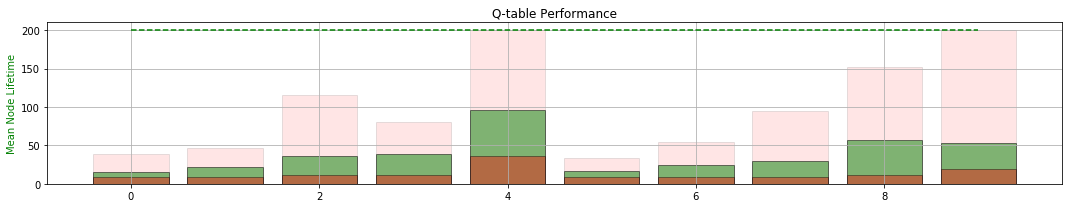

MEMORY COUNTER:  61589
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.528	LOSS : 3.489	LOSS : 3.597	LOSS : 3.341	LOSS : 3.575	LOSS : 3.701	
Validating... MEAN TIME:  130.8
LOSS : 3.587	LOSS : 3.536	LOSS : 3.567	LOSS : 3.501	LOSS : 3.484	LOSS : 3.586	
Validating... MEAN TIME:  169.235
LOSS : 3.478	LOSS : 3.615	LOSS : 3.452	LOSS : 3.479	LOSS : 3.418	LOSS : 3.361	
Validating... MEAN TIME:  181.27
LOSS : 3.401	LOSS : 3.617	LOSS : 3.472	LOSS : 3.453	LOSS : 3.464	LOSS : 3.326	
Validating... MEAN TIME:  189.085
LOSS : 3.362	LOSS : 3.534	LOSS : 3.244	LOSS : 3.369	LOSS : 3.158	LOSS : 3.381	
Validating... MEAN TIME:  195.825
TRAINING TIME:0:00:47.859711


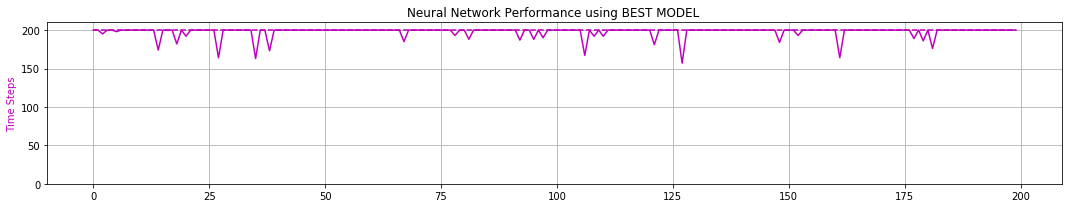

peak memory: 1377.10 MiB, increment: 1017.63 MiB
0 -max- [ 0.058  0.524  0.209  2.746]
0 -min- [-0.213 -1.801 -0.049 -0.373]

1 -max- [ 0.247  1.557  0.046  0.377]
1 -min- [-0.085 -0.570 -0.209 -2.536]

2 -max- [ 0.300  1.250  0.209  2.608]
2 -min- [-0.641 -1.801 -0.207 -0.804]

3 -max- [ 0.318  1.221  0.050  0.381]
3 -min- [-0.127 -0.577 -0.209 -1.999]

4 -max- [ 2.398  3.142  0.209  1.530]
4 -min- [-0.700 -1.272 -0.209 -1.025]

5 -max- [ 0.230  1.797  0.051  0.331]
5 -min- [-0.055 -0.356 -0.209 -2.753]

6 -max- [ 0.197  0.715  0.209  2.422]
6 -min- [-0.223 -1.590 -0.050 -0.441]

7 -max- [ 0.547  1.610  0.067  0.436]
7 -min- [-0.093 -0.575 -0.209 -2.341]

8 -max- [ 1.980  2.600  0.209  2.268]
8 -min- [-1.563 -1.829 -0.206 -0.914]

9 -max- [ 1.030  1.540  0.086  0.436]
9 -min- [-0.224 -0.742 -0.209 -1.670]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 9
REAL TIME TO GENERATE 63687 EXPERIENCES:0:00:02.400035


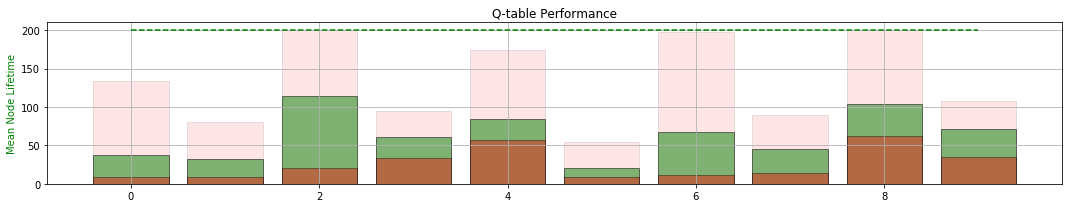

MEMORY COUNTER:  125276
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.660	LOSS : 2.789	LOSS : 2.746	LOSS : 2.560	LOSS : 2.633	LOSS : 2.554	
Validating... MEAN TIME:  199.07
LOSS : 2.550	LOSS : 2.486	LOSS : 2.666	LOSS : 2.672	LOSS : 2.463	LOSS : 2.596	
Validating... MEAN TIME:  199.355
LOSS : 2.485	LOSS : 2.425	LOSS : 2.709	LOSS : 2.580	LOSS : 2.422	LOSS : 2.612	
Validating... MEAN TIME:  200.0
LOSS : 2.484	LOSS : 2.679	LOSS : 2.533	LOSS : 2.690	LOSS : 2.549	LOSS : 2.518	
Validating... MEAN TIME:  200.0
LOSS : 2.305	LOSS : 2.546	LOSS : 2.467	LOSS : 2.527	LOSS : 2.504	LOSS : 2.684	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:52.675972


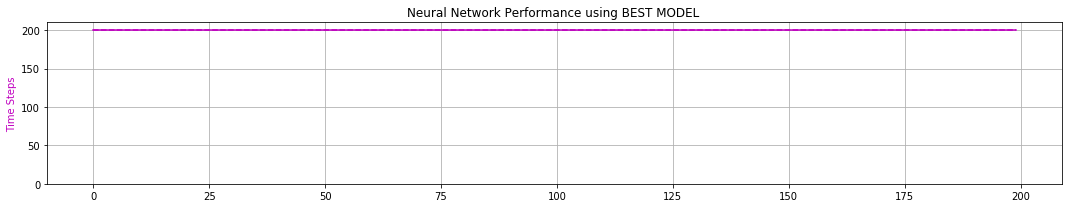

peak memory: 1406.63 MiB, increment: 1037.06 MiB
0 -max- [ 1.613  1.861  0.209  2.689]
0 -min- [-1.499 -2.280 -0.111 -0.597]

1 -max- [ 0.226  1.353  0.049  0.404]
1 -min- [-0.324 -1.052 -0.209 -2.254]

2 -max- [ 2.399  2.544  0.208  1.957]
2 -min- [-2.397 -2.776 -0.209 -0.756]

3 -max- [ 0.192  0.782  0.050  0.412]
3 -min- [-0.572 -1.325 -0.209 -1.344]

4 -max- [ 0.434  0.593  0.056  0.857]
4 -min- [-1.097 -1.676 -0.209 -0.590]

5 -max- [ 0.217  1.554  0.050  0.397]
5 -min- [-0.238 -0.897 -0.209 -2.482]

6 -max- [ 2.389  2.581  0.209  2.444]
6 -min- [-2.385 -2.940 -0.207 -0.694]

7 -max- [ 0.209  1.188  0.049  0.409]
7 -min- [-0.412 -1.122 -0.209 -1.992]

8 -max- [ 2.391  1.812  0.136  1.289]
8 -min- [-1.575 -2.040 -0.209 -0.754]

9 -max- [ 0.195  0.616  0.049  0.411]
9 -min- [-0.608 -1.324 -0.209 -1.308]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 10
REAL TIME TO GENERATE 122152 EXPERIENCES:0:00:03.803826


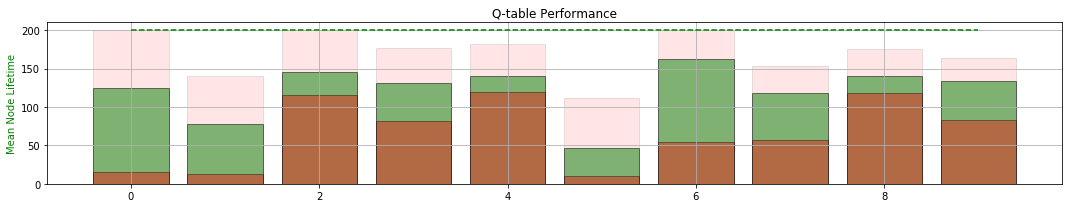

MEMORY COUNTER:  247428
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.687	LOSS : 1.810	LOSS : 1.656	LOSS : 1.748	LOSS : 1.770	LOSS : 1.820	
Validating... MEAN TIME:  200.0
LOSS : 1.673	LOSS : 1.719	LOSS : 1.657	LOSS : 1.791	LOSS : 1.722	LOSS : 1.922	
Validating... MEAN TIME:  200.0
LOSS : 1.733	LOSS : 1.669	LOSS : 1.772	LOSS : 1.770	LOSS : 1.835	LOSS : 1.938	
Validating... MEAN TIME:  200.0
LOSS : 1.821	LOSS : 1.728	LOSS : 1.816	LOSS : 1.683	LOSS : 1.741	LOSS : 1.774	
Validating... MEAN TIME:  200.0
LOSS : 1.685	LOSS : 1.678	LOSS : 1.814	LOSS : 1.788	LOSS : 1.691	LOSS : 1.663	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:52.823228


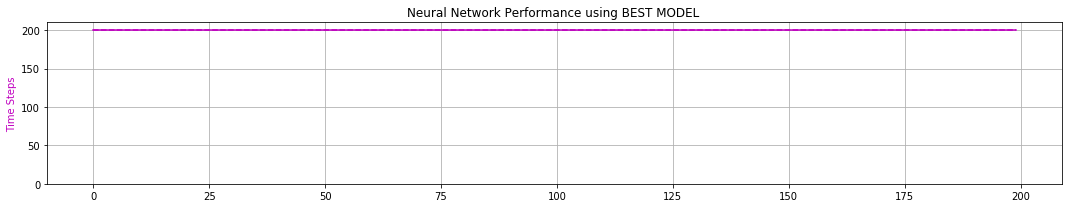

peak memory: 1426.58 MiB, increment: 1017.89 MiB
0 -max- [ 2.397  2.795  0.209  2.233]
0 -min- [-2.398 -2.544 -0.147 -0.961]

1 -max- [ 0.216  1.020  0.050  0.418]
1 -min- [-2.040 -2.371 -0.209 -1.810]

2 -max- [ 0.199  0.627  0.209  1.275]
2 -min- [-2.400 -2.720 -0.209 -0.738]

3 -max- [ 0.212  0.623  0.051  0.422]
3 -min- [-2.400 -2.599 -0.209 -1.251]

4 -max- [ 0.220  0.587  0.055  0.743]
4 -min- [-2.399 -2.604 -0.209 -0.667]

5 -max- [ 0.209  1.571  0.050  0.413]
5 -min- [-2.039 -2.364 -0.209 -2.366]

6 -max- [ 2.377  2.041  0.208  1.586]
6 -min- [-2.400 -2.734 -0.198 -0.911]

7 -max- [ 0.210  0.639  0.048  0.421]
7 -min- [-2.373 -2.540 -0.209 -1.310]

8 -max- [ 0.179  0.433  0.049  0.921]
8 -min- [-2.399 -2.700 -0.209 -0.586]

9 -max- [ 0.197  0.633  0.049  0.421]
9 -min- [-2.393 -2.599 -0.209 -1.001]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 16
REAL TIME TO GENERATE 131620 EXPERIENCES:0:00:03.608896


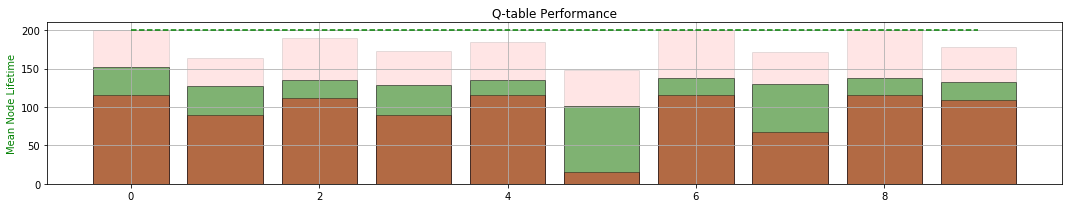

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.035	LOSS : 1.072	LOSS : 1.078	LOSS : 1.062	LOSS : 1.138	LOSS : 1.228	
Validating... MEAN TIME:  159.695
LOSS : 1.089	LOSS : 1.145	LOSS : 1.109	LOSS : 1.131	LOSS : 1.036	LOSS : 1.245	
Validating... MEAN TIME:  180.355
LOSS : 1.145	LOSS : 1.193	LOSS : 1.132	LOSS : 1.115	LOSS : 1.163	LOSS : 1.138	
Validating... MEAN TIME:  164.6
LOSS : 1.081	LOSS : 1.041	LOSS : 1.218	LOSS : 1.121	LOSS : 1.131	LOSS : 1.024	
Validating... MEAN TIME:  164.56
LOSS : 1.274	LOSS : 1.221	LOSS : 1.107	LOSS : 0.976	LOSS : 1.078	LOSS : 1.169	
Validating... MEAN TIME:  199.38
TRAINING TIME:0:00:48.427396


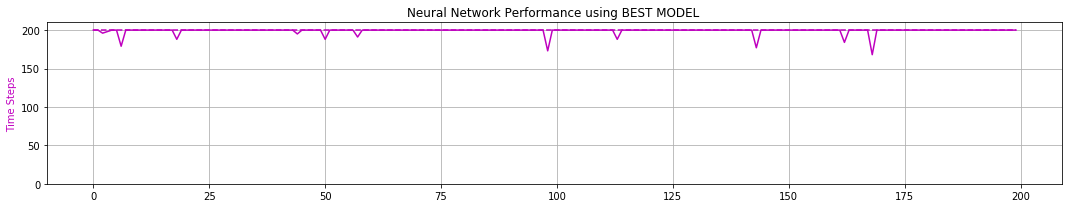

peak memory: 1453.55 MiB, increment: 1025.47 MiB
0 -max- [ 0.523  1.296  0.179  1.658]
0 -min- [-2.399 -3.116 -0.193 -0.739]

1 -max- [ 0.174  0.825  0.050  0.422]
1 -min- [-2.400 -2.774 -0.209 -1.208]

2 -max- [ 0.207  0.438  0.051  0.847]
2 -min- [-2.399 -2.976 -0.208 -0.603]

3 -max- [ 0.203  0.599  0.050  0.421]
3 -min- [-2.399 -2.767 -0.209 -1.119]

4 -max- [ 0.201  0.440  0.050  0.887]
4 -min- [-2.400 -2.943 -0.207 -0.598]

5 -max- [ 0.194  0.993  0.049  0.421]
5 -min- [-2.386 -2.711 -0.209 -1.568]

6 -max- [ 0.309  0.609  0.064  0.995]
6 -min- [-2.400 -2.991 -0.209 -0.721]

7 -max- [ 0.178  0.627  0.049  0.427]
7 -min- [-2.400 -2.877 -0.209 -1.292]

8 -max- [ 0.323  0.552  0.049  0.680]
8 -min- [-2.400 -2.872 -0.208 -0.716]

9 -max- [ 0.209  0.565  0.050  0.419]
9 -min- [-2.400 -2.881 -0.209 -1.016]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 71
REAL TIME TO GENERATE 120045 EXPERIENCES:0:00:02.971611


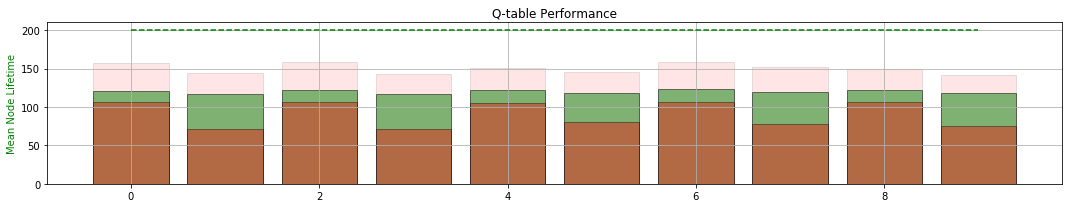

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.005	LOSS : 0.967	LOSS : 0.955	LOSS : 0.975	LOSS : 0.888	LOSS : 0.949	
Validating... MEAN TIME:  139.945
LOSS : 0.968	LOSS : 1.076	LOSS : 0.852	LOSS : 0.908	LOSS : 0.981	LOSS : 0.924	
Validating... MEAN TIME:  141.485
LOSS : 1.025	LOSS : 0.886	LOSS : 0.780	LOSS : 0.971	LOSS : 0.903	LOSS : 0.880	
Validating... MEAN TIME:  142.6
LOSS : 0.888	LOSS : 0.914	LOSS : 0.980	LOSS : 0.948	LOSS : 0.840	LOSS : 0.860	
Validating... MEAN TIME:  140.785
LOSS : 0.869	LOSS : 0.929	LOSS : 0.886	LOSS : 0.845	LOSS : 0.896	LOSS : 0.871	
Validating... MEAN TIME:  141.68
TRAINING TIME:0:00:44.365575


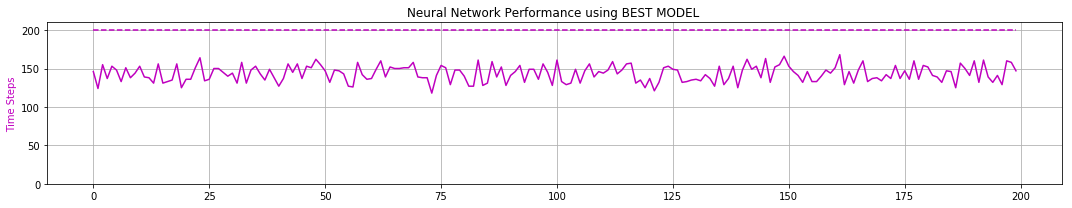

peak memory: 1423.25 MiB, increment: 1011.72 MiB
0 -max- [ 0.138  0.619  0.050  0.842]
0 -min- [-2.399 -2.962 -0.196 -0.751]

1 -max- [ 0.162  0.610  0.051  0.416]
1 -min- [-2.400 -3.119 -0.209 -1.026]

2 -max- [ 0.167  0.590  0.053  0.803]
2 -min- [-2.399 -3.140 -0.191 -0.735]

3 -max- [ 0.162  0.840  0.050  0.415]
3 -min- [-2.399 -3.097 -0.209 -1.369]

4 -max- [ 0.146  0.439  0.049  0.926]
4 -min- [-2.400 -2.977 -0.192 -0.616]

5 -max- [ 0.142  0.798  0.048  0.419]
5 -min- [-2.400 -3.070 -0.207 -1.155]

6 -max- [ 0.143  0.596  0.061  0.846]
6 -min- [-2.400 -3.127 -0.190 -0.746]

7 -max- [ 0.150  0.608  0.049  0.415]
7 -min- [-2.400 -3.062 -0.209 -1.025]

8 -max- [ 0.140  0.439  0.050  0.780]
8 -min- [-2.400 -2.971 -0.192 -0.612]

9 -max- [ 0.162  0.624  0.045  0.416]
9 -min- [-2.400 -3.071 -0.209 -0.906]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 29
REAL TIME TO GENERATE 76021 EXPERIENCES:0:00:01.778342


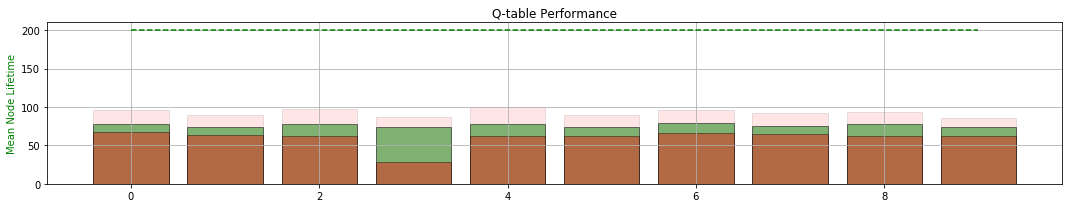

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.214	LOSS : 1.021	LOSS : 1.027	LOSS : 0.947	LOSS : 0.995	LOSS : 1.049	
Validating... MEAN TIME:  133.66
LOSS : 1.036	LOSS : 0.953	LOSS : 1.012	LOSS : 1.010	LOSS : 0.990	LOSS : 1.200	
Validating... MEAN TIME:  126.265
LOSS : 1.046	LOSS : 1.143	LOSS : 1.106	LOSS : 1.010	LOSS : 1.011	LOSS : 1.136	
Validating... MEAN TIME:  129.485
LOSS : 0.910	LOSS : 1.001	LOSS : 0.950	LOSS : 1.006	LOSS : 1.081	LOSS : 1.075	
Validating... MEAN TIME:  136.045
LOSS : 0.966	LOSS : 1.067	LOSS : 1.049	LOSS : 1.105	LOSS : 1.007	LOSS : 1.066	
Validating... MEAN TIME:  134.265
TRAINING TIME:0:00:41.446957


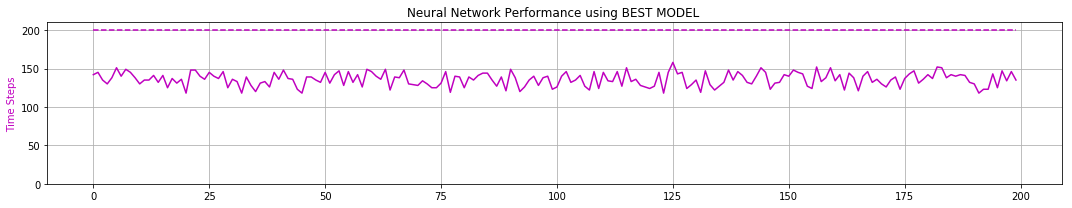

peak memory: 1475.00 MiB, increment: 1024.38 MiB
0 -max- [ 0.172  0.795  0.059  0.658]
0 -min- [-1.216 -1.870 -0.209 -1.026]

1 -max- [ 0.159  0.778  0.050  0.408]
1 -min- [-0.907 -1.802 -0.209 -1.154]

2 -max- [ 0.149  0.633  0.050  0.625]
2 -min- [-1.223 -2.008 -0.209 -0.838]

3 -max- [ 0.145  0.820  0.049  0.409]
3 -min- [-0.932 -1.799 -0.209 -1.138]

4 -max- [ 0.134  0.616  0.053  0.873]
4 -min- [-1.112 -1.985 -0.209 -0.886]

5 -max- [ 0.138  0.631  0.049  0.410]
5 -min- [-0.936 -1.832 -0.209 -0.932]

6 -max- [ 0.139  0.629  0.049  0.655]
6 -min- [-1.166 -1.985 -0.209 -0.881]

7 -max- [ 0.144  0.627  0.050  0.409]
7 -min- [-0.928 -1.790 -0.209 -1.102]

8 -max- [ 0.153  0.633  0.045  0.722]
8 -min- [-1.279 -2.021 -0.209 -0.837]

9 -max- [ 0.131  0.632  0.045  0.409]
9 -min- [-0.946 -1.775 -0.209 -1.034]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 22
REAL TIME TO GENERATE 103748 EXPERIENCES:0:00:02.517523


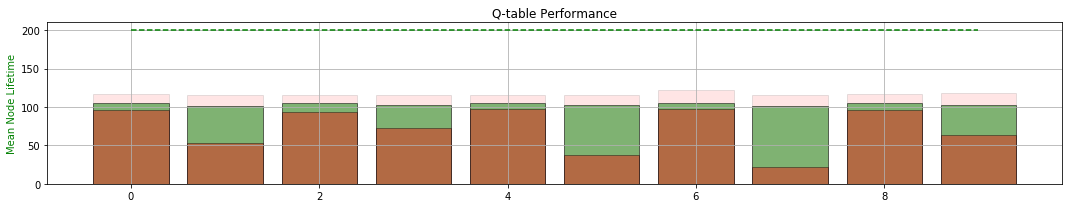

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.268	LOSS : 1.083	LOSS : 0.992	LOSS : 1.135	LOSS : 1.046	LOSS : 0.958	
Validating... MEAN TIME:  120.64
LOSS : 1.097	LOSS : 0.999	LOSS : 1.176	LOSS : 1.128	LOSS : 1.137	LOSS : 1.236	
Validating... MEAN TIME:  127.275
LOSS : 1.057	LOSS : 1.023	LOSS : 1.092	LOSS : 1.006	LOSS : 0.940	LOSS : 1.208	
Validating... MEAN TIME:  120.31
LOSS : 1.097	LOSS : 1.011	LOSS : 1.032	LOSS : 1.032	LOSS : 1.061	LOSS : 1.028	
Validating... MEAN TIME:  124.225
LOSS : 1.094	LOSS : 1.260	LOSS : 1.060	LOSS : 1.085	LOSS : 1.125	LOSS : 1.155	
Validating... MEAN TIME:  125.725
TRAINING TIME:0:00:39.899219


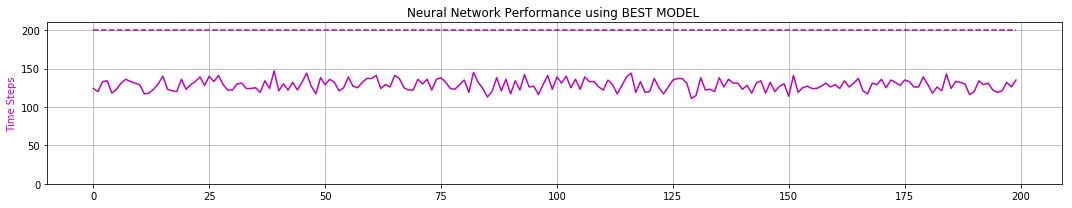

peak memory: 1433.93 MiB, increment: 1016.72 MiB
0 -max- [ 0.173  0.635  0.050  0.751]
0 -min- [-2.399 -3.136 -0.190 -0.948]

1 -max- [ 0.156  0.817  0.050  0.580]
1 -min- [-2.399 -3.333 -0.209 -1.228]

2 -max- [ 0.152  0.634  0.049  0.862]
2 -min- [-2.399 -3.116 -0.190 -0.940]

3 -max- [ 0.182  0.826  0.048  0.474]
3 -min- [-2.400 -3.132 -0.209 -1.262]

4 -max- [ 0.148  0.635  0.049  1.039]
4 -min- [-2.399 -3.342 -0.191 -0.946]

5 -max- [ 0.165  0.830  0.049  0.523]
5 -min- [-2.399 -3.124 -0.209 -1.201]

6 -max- [ 0.164  0.634  0.050  0.709]
6 -min- [-2.400 -3.125 -0.190 -0.947]

7 -max- [ 0.165  0.797  0.045  0.671]
7 -min- [-2.399 -3.313 -0.207 -1.069]

8 -max- [ 0.143  0.632  0.045  0.653]
8 -min- [-2.400 -3.151 -0.191 -0.938]

9 -max- [ 0.181  1.022  0.050  0.685]
9 -min- [-2.400 -3.439 -0.209 -1.445]

Quantization TIME:  0.01 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 10
REAL TIME TO GENERATE 96504 EXPERIENCES:0:00:02.357610


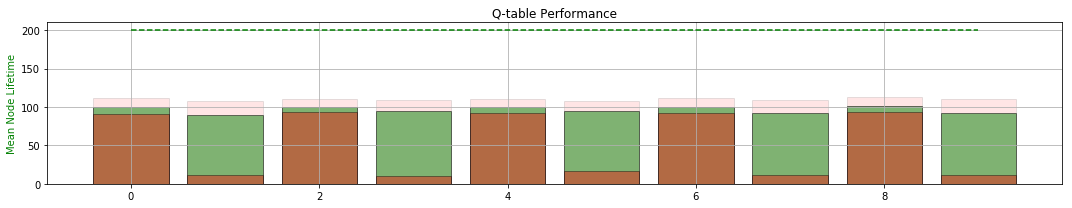

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.185	LOSS : 1.199	LOSS : 1.202	LOSS : 1.188	LOSS : 1.204	LOSS : 1.194	
Validating... MEAN TIME:  115.245
LOSS : 1.211	LOSS : 1.078	LOSS : 1.392	LOSS : 1.168	LOSS : 1.204	LOSS : 1.205	
Validating... MEAN TIME:  115.825
LOSS : 1.215	LOSS : 1.158	LOSS : 1.191	LOSS : 1.083	LOSS : 1.028	LOSS : 1.054	
Validating... MEAN TIME:  115.67
LOSS : 1.124	LOSS : 1.297	LOSS : 1.115	LOSS : 1.176	LOSS : 1.001	LOSS : 1.144	
Validating... MEAN TIME:  115.75
LOSS : 1.114	LOSS : 1.046	LOSS : 1.047	LOSS : 1.139	LOSS : 1.038	LOSS : 1.230	
Validating... MEAN TIME:  122.05
TRAINING TIME:0:00:39.246968


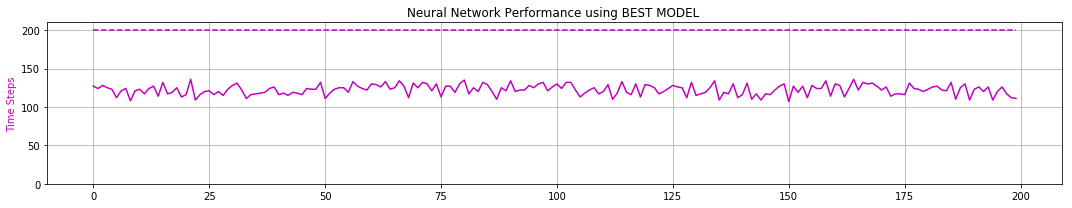

peak memory: 1442.07 MiB, increment: 1017.53 MiB
0 -max- [ 0.187  0.752  0.050  0.750]
0 -min- [-2.400 -3.103 -0.192 -1.068]

1 -max- [ 0.184  0.828  0.049  0.634]
1 -min- [-2.399 -3.321 -0.209 -1.338]

2 -max- [ 0.178  0.639  0.048  0.880]
2 -min- [-2.399 -3.106 -0.190 -1.058]

3 -max- [ 0.185  0.996  0.049  0.673]
3 -min- [-2.400 -3.316 -0.209 -1.644]

4 -max- [ 0.185  0.639  0.049  0.802]
4 -min- [-2.399 -3.088 -0.191 -1.090]

5 -max- [ 0.185  0.826  0.050  0.544]
5 -min- [-2.397 -3.270 -0.209 -1.319]

6 -max- [ 0.190  0.638  0.045  0.922]
6 -min- [-2.399 -3.154 -0.191 -1.065]

7 -max- [ 0.189  0.822  0.045  0.613]
7 -min- [-2.398 -3.315 -0.209 -1.297]

8 -max- [ 0.189  0.638  0.052  0.787]
8 -min- [-2.400 -3.295 -0.193 -1.077]

9 -max- [ 0.182  1.008  0.049  0.623]
9 -min- [-2.400 -3.328 -0.209 -1.628]

Quantization TIME:  0.01 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 11
REAL TIME TO GENERATE 58222 EXPERIENCES:0:00:01.557983


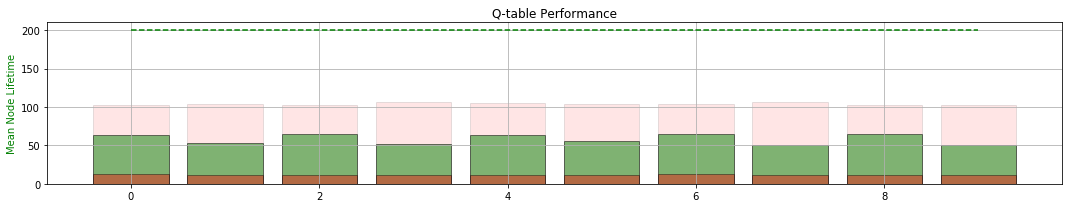

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.200	LOSS : 1.361	LOSS : 1.238	LOSS : 1.206	LOSS : 1.371	LOSS : 1.275	
Validating... MEAN TIME:  125.245
LOSS : 1.277	LOSS : 1.337	LOSS : 1.149	LOSS : 1.164	LOSS : 1.210	LOSS : 1.093	
Validating... MEAN TIME:  121.57
LOSS : 1.417	LOSS : 1.246	LOSS : 1.183	LOSS : 1.325	LOSS : 1.291	LOSS : 1.105	
Validating... MEAN TIME:  125.19
LOSS : 1.221	LOSS : 1.227	LOSS : 1.169	LOSS : 1.354	LOSS : 1.284	LOSS : 1.284	
Validating... MEAN TIME:  131.295
LOSS : 1.182	LOSS : 1.233	LOSS : 1.332	LOSS : 1.200	LOSS : 1.333	LOSS : 1.242	
Validating... MEAN TIME:  131.95
TRAINING TIME:0:00:40.276325


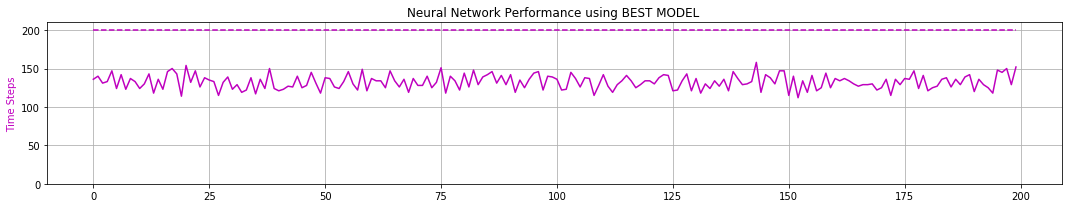

peak memory: 1398.38 MiB, increment: 1017.40 MiB
0 -max- [ 0.204  0.641  0.049  0.797]
0 -min- [-2.400 -3.134 -0.209 -1.107]

1 -max- [ 0.202  0.999  0.048  0.545]
1 -min- [-2.399 -3.157 -0.209 -1.606]

2 -max- [ 0.194  0.643  0.049  0.862]
2 -min- [-2.399 -3.181 -0.209 -1.107]

3 -max- [ 0.208  0.998  0.049  0.401]
3 -min- [-2.398 -3.157 -0.209 -1.553]

4 -max- [ 0.209  0.643  0.050  0.846]
4 -min- [-2.400 -3.133 -0.209 -1.104]

5 -max- [ 0.218  0.961  0.045  0.552]
5 -min- [-2.396 -3.152 -0.209 -1.454]

6 -max- [ 0.186  0.640  0.045  0.722]
6 -min- [-2.399 -3.124 -0.209 -1.108]

7 -max- [ 0.228  0.986  0.050  0.563]
7 -min- [-2.397 -3.275 -0.209 -1.625]

8 -max- [ 0.209  0.645  0.049  0.745]
8 -min- [-2.399 -3.134 -0.209 -1.099]

9 -max- [ 0.213  0.826  0.050  0.396]
9 -min- [-2.399 -3.141 -0.209 -1.455]

Quantization TIME:  0.01 minutes


ITERATION # 10
SMALLEST TIMESTEP in ITERATION 10: 10
REAL TIME TO GENERATE 52689 EXPERIENCES:0:00:01.355332


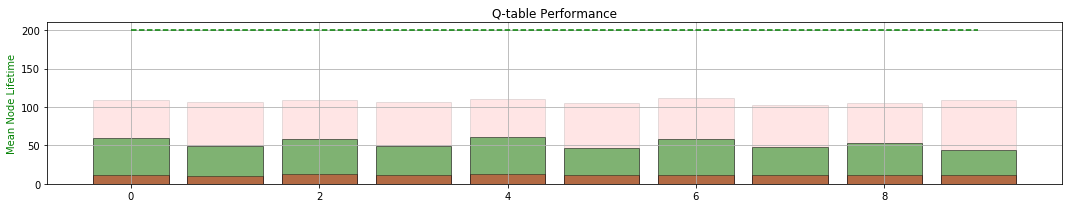

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.363	LOSS : 1.523	LOSS : 1.381	LOSS : 1.379	LOSS : 1.377	LOSS : 1.300	
Validating... MEAN TIME:  124.93
LOSS : 1.243	LOSS : 1.469	LOSS : 1.349	LOSS : 1.239	LOSS : 1.257	LOSS : 1.373	
Validating... MEAN TIME:  124.425
LOSS : 1.319	LOSS : 1.292	LOSS : 1.411	LOSS : 1.450	LOSS : 1.495	LOSS : 1.394	
Validating... MEAN TIME:  129.135
LOSS : 1.385	LOSS : 1.257	LOSS : 1.490	LOSS : 1.438	LOSS : 1.269	LOSS : 1.505	
Validating... MEAN TIME:  130.54
LOSS : 1.272	LOSS : 1.200	LOSS : 1.439	LOSS : 1.315	LOSS : 1.440	LOSS : 1.362	
Validating... MEAN TIME:  124.88
TRAINING TIME:0:00:40.283928


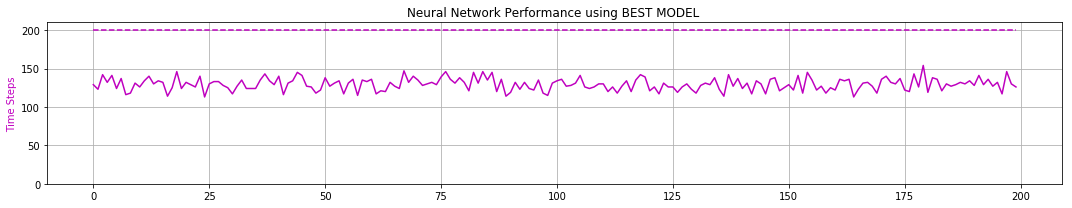

peak memory: 1418.55 MiB, increment: 998.39 MiB
0 -max- [ 0.202  0.642  0.048  0.619]
0 -min- [-2.400 -3.322 -0.209 -1.104]

1 -max- [ 0.195  0.983  0.049  0.393]
1 -min- [-2.396 -3.122 -0.209 -1.628]

2 -max- [ 0.201  0.645  0.049  0.612]
2 -min- [-2.400 -3.268 -0.209 -1.103]

3 -max- [ 0.207  0.826  0.050  0.390]
3 -min- [-2.399 -3.133 -0.209 -1.336]

4 -max- [ 0.211  0.641  0.045  0.758]
4 -min- [-2.400 -3.305 -0.209 -1.104]

5 -max- [ 0.195  0.833  0.045  0.395]
5 -min- [-2.400 -3.134 -0.209 -1.431]

6 -max- [ 0.213  0.645  0.054  0.793]
6 -min- [-2.398 -3.325 -0.209 -1.108]

7 -max- [ 0.213  0.830  0.049  0.399]
7 -min- [-2.395 -3.136 -0.209 -1.412]

8 -max- [ 0.213  0.645  0.050  0.682]
8 -min- [-2.398 -3.138 -0.209 -1.105]

9 -max- [ 0.216  0.833  0.050  0.393]
9 -min- [-2.400 -3.120 -0.209 -1.335]

Quantization TIME:  0.01 minutes


ITERATION # 11
SMALLEST TIMESTEP in ITERATION 11: 10
REAL TIME TO GENERATE 42812 EXPERIENCES:0:00:01.099947


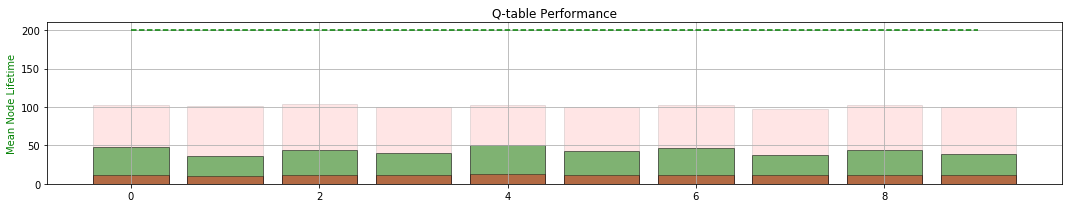

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.655	LOSS : 1.734	LOSS : 1.496	LOSS : 1.527	LOSS : 1.497	LOSS : 1.311	
Validating... MEAN TIME:  195.98
LOSS : 1.850	LOSS : 1.683	LOSS : 1.780	LOSS : 1.523	LOSS : 1.484	LOSS : 1.455	
Validating... MEAN TIME:  198.67
LOSS : 1.521	LOSS : 1.591	LOSS : 1.632	LOSS : 1.747	LOSS : 1.639	LOSS : 1.582	
Validating... MEAN TIME:  166.205
LOSS : 1.602	LOSS : 1.859	LOSS : 1.756	LOSS : 1.615	LOSS : 1.401	LOSS : 1.555	
Validating... MEAN TIME:  191.51
LOSS : 1.522	LOSS : 1.486	LOSS : 1.650	LOSS : 1.645	LOSS : 1.602	LOSS : 1.554	
Validating... MEAN TIME:  128.025
TRAINING TIME:0:00:49.136732


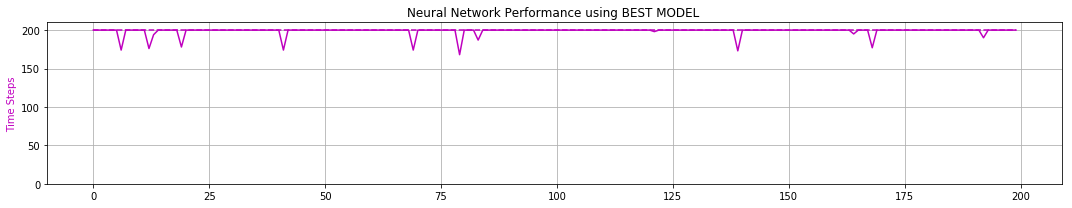

peak memory: 1398.31 MiB, increment: 1017.15 MiB
0 -max- [ 0.198  0.643  0.052  0.776]
0 -min- [-2.394 -3.335 -0.209 -1.103]

1 -max- [ 0.209  1.010  0.049  0.383]
1 -min- [-2.386 -3.311 -0.209 -1.709]

2 -max- [ 0.204  0.641  0.050  0.608]
2 -min- [-2.398 -3.341 -0.209 -1.102]

3 -max- [ 0.210  0.835  0.045  0.384]
3 -min- [-2.386 -3.338 -0.209 -1.393]

4 -max- [ 0.195  0.640  0.045  0.619]
4 -min- [-2.398 -3.455 -0.209 -1.101]

5 -max- [ 0.213  0.839  0.050  0.385]
5 -min- [-2.399 -3.272 -0.209 -1.438]

6 -max- [ 0.209  0.773  0.055  0.692]
6 -min- [-2.395 -3.329 -0.209 -1.103]

7 -max- [ 0.213  0.826  0.050  0.384]
7 -min- [-2.392 -3.320 -0.209 -1.438]

8 -max- [ 0.208  0.816  0.051  0.580]
8 -min- [-2.398 -3.442 -0.209 -1.105]

9 -max- [ 0.205  0.988  0.050  0.384]
9 -min- [-2.380 -3.331 -0.209 -1.555]

Quantization TIME:  0.01 minutes


ITERATION # 12
SMALLEST TIMESTEP in ITERATION 12: 11
REAL TIME TO GENERATE 74966 EXPERIENCES:0:00:01.801081


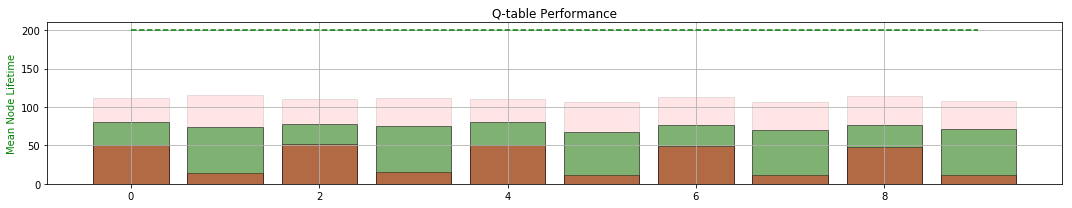

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.818	LOSS : 1.790	LOSS : 1.651	LOSS : 1.759	LOSS : 1.530	LOSS : 1.894	
Validating... MEAN TIME:  141.73
LOSS : 1.672	LOSS : 1.791	LOSS : 1.595	LOSS : 1.613	LOSS : 1.641	LOSS : 1.644	
Validating... MEAN TIME:  141.405
LOSS : 1.715	LOSS : 1.914	LOSS : 1.616	LOSS : 1.802	LOSS : 1.830	LOSS : 1.519	
Validating... MEAN TIME:  196.89
LOSS : 1.758	LOSS : 1.668	LOSS : 1.605	LOSS : 1.585	LOSS : 1.834	LOSS : 1.780	
Validating... MEAN TIME:  146.63
LOSS : 1.556	LOSS : 1.678	LOSS : 1.955	LOSS : 1.621	

In [ ]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [ ]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))